In [31]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pystan
import seaborn as sns
import scipy as sp

# __Bayesian Inference on Spotify Streams__
#### Project work by __Ville Saarinen__ and __Sirong Huang__
## __Introduction__
The purpose of this project work is to study the features of most played (only the top 100 were selected) Spotify songs by geography and see if fitting a variety of different regression models could yield us information about the relationship of the features to the popularity of the songs. Here we assume that the amount of streams each song has is closely coupled with its popularity. However we are aware that the true  determining the popularity of any given song is extremely complex and that there is very probably many exogeneous factors (song's popularity is to some degree dependent on the popularity of the artist, artist's connectivity socially, cultural aspects, marketing-related, geographical etc) that are not captured by the musical features of the songs. We also need to take into consideration the fact that even the musical qualities are not completely accurately captured by the features offered by the Spotify API, bur rather they are algorithmically computed approximations of the qualities they are supposed to model.   

We then proceed by showing that by conducting Bayesian inference on different geographical areas we can identify some of the culturally / geographically determined features which determine given song's popularity in that particular context.

#### __This notebook is structured in a following way:__
1. Data import and implementing common methods used throughout the model assessment and inference
2. __Introducing bayesian linear regression model__  
    2.1 Model  
    2.2 Intuitions about the Data
    2.3 Priors
3. __Modeling and inference__  
    3.1 3-covariate model with uninformative priors  
    3.2 3-covariate model with normal priors  
    3.3 5-covariate model with normal priors  
    3.4 Extended 5-covariate model with 2 interaction terms  
    3.5 Extended 5-covariate model with 4 interaction terms  
    3.6 Extended 5-covariate model with squared terms  
    3.7 Extended 5-covariate model with squared and interaction terms  
    3.8 Extended 5-covariate model with cubic and interaction terms
4. __Model comparison__
5. __Limiting the domain and inference about cultural differences__
6. __Conclusions__

## __1. Data Import and Common Methods__

#### Import stan convergence utilities from local directory 
Utilities originally by Betancourt, [see this notebook on Bayesian workflow](http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html).

In [32]:
%run utility/stan_utility.py

#### Import data

In [55]:
names = ['streams', 'acousticness', 'danceability', 'energy', 'loudness', 'tempo', 'valence']
names_2018 = ['streams', 'acousticness', 'danceability', 'loudness', 'tempo', 'valence']

global_data  = pd.read_csv('./data/global_selected.csv',header=None, names=names)
finland_data = pd.read_csv('./data/finland_selected.csv',header=None, names=names)
sweden_data  = pd.read_csv('./data/sweden_selected.csv',header=None, names=names)

global_data_2018 = pd.read_csv('./data/2018_global_selected.csv',header=None, names=names)
global_songs_2018 = pd.read_csv('./data/2018_global.csv')

#### Methods for saving and loading models

In [34]:
def save_model(model, filename):
    """Saves the compiled model to file."""
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

def load_model(filename):
    """Load already compiled model from file."""
    return pickle.load(open(filename, 'rb'))

#### Method for plotting predictive distributions

In [35]:
def plot_predictive_acc(global_data, global_data_2018, samples):
    fig, [ax1, ax2] = plt.subplots(2,1,figsize=(16,9), sharex=True)

    plt.suptitle('Predictive performance')
    plt.xlabel('Song ranking by stream count')
    cols = ['blue','orange','grey']

    plt.ylim(0,1)
    plt.xticks(range(1,101),labels=['{0}'.format(i) if i % 2 != 0 else '' for i in range(1,101)])
    X_top100 = range(1,101)

    ax1.plot(X_top100, global_data['streams'], '.--', color=cols[0], alpha=.5, label='Top songs for 2017')
    ax1.plot(X_top100, np.mean(samples['ypred'], axis=0),  '.-', color=cols[1], label='Prediction')
    sns.regplot(list(X_top100), list(np.mean(samples['ypred'], axis=0)), 'o-', color=cols[2], ax=ax1, scatter=False, 
                label='Prediction regression fit with 95%-ci')

    ax1.legend(loc='best')
    ax1.set_ylabel('Streams')

    ax2.plot(X_top100, global_data_2018['streams'], '.-', color=cols[0], alpha=.5, label='Top songs for 2017')
    ax2.plot(X_top100, np.mean(samples['ypred_2018'], axis=0),  '.-', color=cols[1], label='Prediction')
    sns.regplot(list(X_top100), list(np.mean(samples['ypred_2018'], axis=0)), 'o-', color=cols[2], ax=ax2, scatter=False, 
                label='Prediction regression fit with 95%-ci')
    ax2.legend(loc='best')
    ax2.set_ylabel('Streams')

    plt.tight_layout()

#### Setting up Dataframe to Accommodate Model Comparison

In [ ]:
loos = pd.DataFrame(index=[], columns=["loo", "ploo", "dloo", "weight", "se", "dse", "warning", "treedepth", "E-BFMI", "div"])
samples_list = []

## __2. Introducing Bayesian Linear Regression Model__

### __2.1 Model__
#### __Motivation__ 
We are interested in finding out which features in the spotify's song data determine the number of streams in Spotify. We will study this hypothesis by using multiple linear models which model the linear relationship between the variable that includes data about the number of streams with other variables which we use as predictors.

#### __Assumptions__
We first assume that the relationship between $d$-dimension predictor variables $X = \{X_1,X_2,...,X_d\}$ each having $n$ elements, and observations $Y = \{y_1,y_2,...,y_n\}$ (streams) is modeled by *linear dependence*. We also assume that all elements $y \in Y$ and $x \in X$ are independent of each other. 

The mean $\mu$ of model is described by: $\mu = \mathbb{E}[y_i \mid \beta, X] = \alpha + \beta_1 X_1 + \beta_2 X_2 + , ... , + \beta_d X_d\;$, where $\alpha$ is the intercept and $\beta = \{\beta_1, \beta_2, ... , \beta_d\}$ the parameter vector for coefficients.

We also need to consider the unknown error term $\sigma$. Thus in general form our model is of the form:  

$$\large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_d X_d, \;\sigma)$$

In bayesian context we are not interested about point-estimate, but rather the whole posterior distribution which takes the form:

$$\large p(\beta \mid y, X) = \frac{p(y \mid \beta,X)p(\beta\mid X)}{p(y\mid X)}$$

Exploratory data analysis showed that $Y$ is right skewed, this could suggest that our model would benefit from log-transformation. Let's take a closer look at the distribution of $Y$:

/home/zenist/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


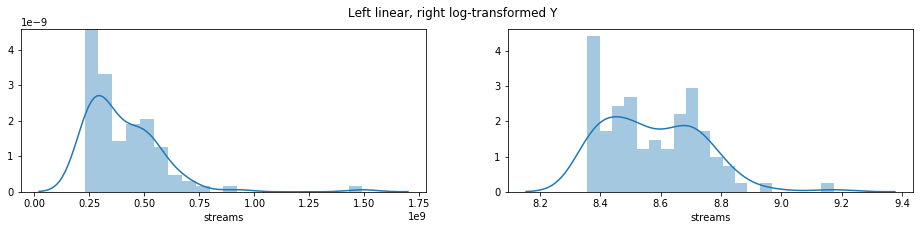

In [37]:
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(16,3))
fig.suptitle('Left linear, right log-transformed Y')
sns.distplot(global_data['streams'], ax=ax1, bins=20)
sns.distplot(np.log10(global_data['streams']), ax=ax2, bins=20)

#### Scaling streaming data
For easier interpretability we will scale the streams used in the linear models to interval $[0,1]$ which means that any $y$ is measured in proportion to the highest performing song.   
We will also explore log-transformed models and produce another copy of the data for that particular purpose:

In [13]:
stream_global_max = np.max(global_data['streams'])
for data in [global_data, finland_data, sweden_data]:
    data['streams'] = data['streams'].values / stream_global_max

In [14]:
global_data_log = global_data
global_data_log['streams'] = np.log10(global_data_log['streams'])

### __2.2 Intuitions About the Data__
Generally we know that the true determining factors of $Y$ are extremely complex and that developing rational and workable intuitions about the $\beta$-priors is a difficult task. The task gets even more difficult as the complexity of the model increases. However we can make basic hypothesis about the way in which different predictors might affect $Y$ and do limited sensitivity analysis based on that. Based on prior knowledge we could hypothesize for example that `loudness` might be a necessary (but not sufficient) component in contemporary music for achieving popularity (there has been extensive discussion about so called 'loudness wars' in the audio engineering industry, see for example [this](https://www.soundonsound.com/sound-advice/dynamic-range-loudness-war)).

In [178]:
def plot_loudness(global_data, global_data_2018, label):
    fig = plt.figure(figsize=(18,5))
    fig.suptitle(label)
    ax1 = plt.subplot2grid((2,5), (0,0), colspan=4, rowspan=2)
    ax1.set_title('Loudness by ranking')
    
    ax1.set_ylabel('Loudness')
    ax1.set_xlabel('Song Ranking')
    ax1.plot(global_data.index.values, global_data['loudness'], '.-', label='2017 songs')
    ax1.plot(global_data_2018.index.values, global_data_2018['loudness'], '.-', label='2018 songs')
    ax1.set_ylim(-4,4)
    ax1.legend()

    ax2 = plt.subplot2grid((2,5), (0,4), colspan=1, rowspan=1)
    ax2.set_title('Loudness kde')

    sns.distplot(global_data['loudness'], hist=True, kde=True, ax=ax2)
    ax2.set_xlabel('loudness')
    
    ax3 = plt.subplot2grid((2,5), (1,4), colspan=1, rowspan=1)    
    sns.distplot(global_data_2018['loudness'], color='orange', hist=True, kde=True, ax=ax3)
    ax3.set_xlabel('loudness')

/home/zenist/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


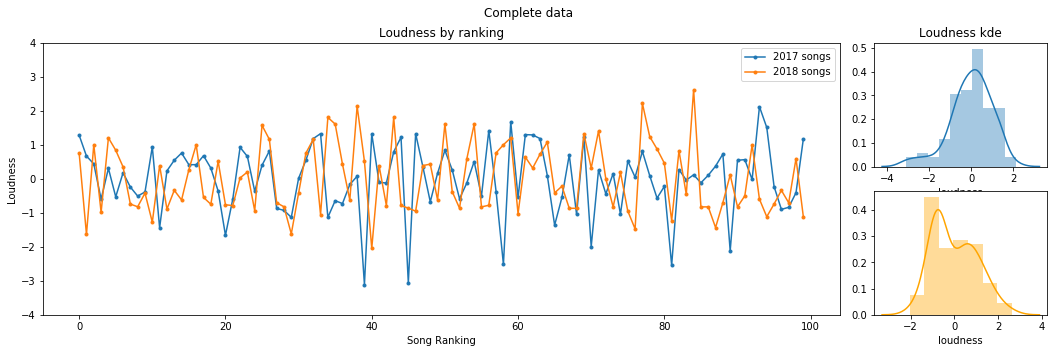

In [179]:
plot_loudness(global_data, global_data_2018, 'Complete data')

We can see quite even and symmetric distributions centered around 0 which doesn't seem to support the `loudness` hypothesis. We can further eplain this by noticing that there are slower songs and ballads also in the mix. Thus by further hypothesizing that songs with high `acousticness` and low `danceability` scores are less loud than for example electronic music that is usually highly compressed and thus easier to make loud. If we remove songs that are highly acoustic and non-danceable, we get:

/home/zenist/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


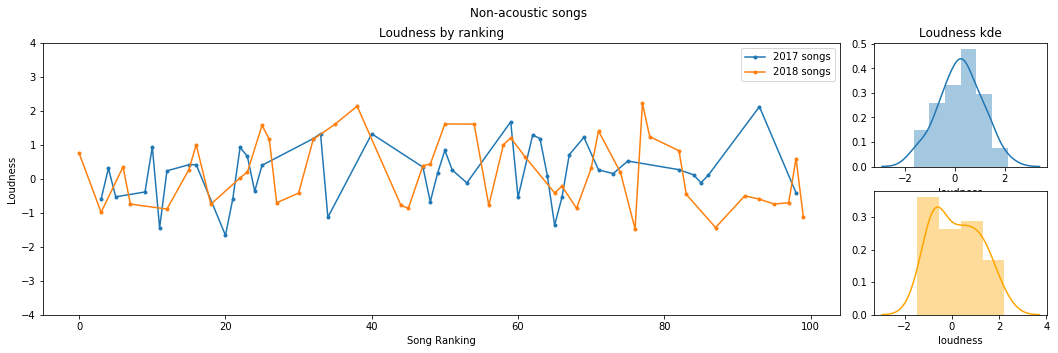

In [180]:
glob_non_ac = global_data[global_data['acousticness'] < -.5]
glob_non_ac_2018 = global_data_2018[global_data_2018['acousticness'] < -.5]
plot_loudness(glob_non_ac, glob_non_ac_2018, 'Non-acoustic songs')

/home/zenist/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


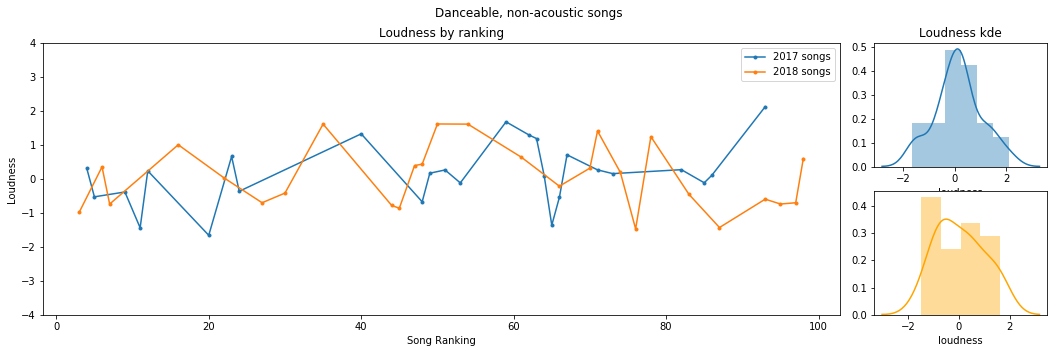

In [181]:
glob_non_ac = glob_non_ac[glob_non_ac['danceability'] > 0]
glob_non_ac_2018 = glob_non_ac_2018[glob_non_ac_2018['danceability'] > 0]
plot_loudness(glob_non_ac, glob_non_ac_2018, 'Danceable, non-acoustic songs')

Observations that are left after the filtering are quite homogenously distributed along the ordered top 100 observations. Kernel density estimates show that the mean has not significantly moved towards more loudness. We can see that our simple hypothesis even about which features determine `loudness` didn't survive through simple exploration of the data. This just goes on to show that it is difficult to understand the true complexity of the data let alone make intuitive explanations about underlying data generating process.

## __2. Priors__
In light of our a priori understanding about the data, what can we then say about distribution of priors? In our model $\alpha$ determines the intercept point $x_0$ where $y=0$. However already this is difficult to have clear intuitions about in higher dimensions. We also have $\beta$-coefficients which together determine the slope of the line. As we saw in the previous sub-section, it is not trivial to develop well working intuitions about the way in which predictors affect the $Y$. As our domain knowledge is very restricted (compared to for example data analyst who have been working with this type of audio streaming data sets for years), we feel that in this particular case it is better to let the observed data drive the conclusions. Thus we will only use uninformative or weakly informative priors. 

## __3. Modeling and Inference__

In this notebook each model will go through following stages:     
  * Justifying prior selection
  * Convergence diagnostics
  * Predictive distribution checking
  * Model evaluation

## __3.1 Uninformative model__ | Three predictors with uninformative priors
For the first model we select only three of the predictor variables based on 1) feature importance based on random forest (pre-processing-notebook) 2) collinearity (EDA-notebook) -- because of the assumptions of the linear model, we want to avoid highly collinear pairs such as `loudness ~ energy` and `valence` which is potentially collinear with many other covariates. Following predictors for this models are `danceability, acousticness` and `tempo`. 

Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$


We start the modeling with uninformative priors. This type of simple model gives us a crude picture of what the bayesian inference can tell us about the data, and it gives us a reference model which we can then compare the more complex models on.  
Here we let Stan take care of the priors, and it chooses __*uniform priors by default*__. This is also known as the *ordinary linear regression*:

### __Load model__

In [182]:
model_name = ['Model 1: 3 Predictors, Uninformative']
filename = 'lin_3_uninformative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred; 
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred_2018;
    vector[N] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred_2018[j] = normal_rng(a + b[1]*X1pred[j] + b[2]*X2pred[j] + b[3]*X3pred[j], sigma);
        ypred[j] = normal_rng(a + b[1]*X1[j] + b[2]*X2[j] + b[

## __2.2 Weakly Informative model 1__ | Three predictors with normal priors
One of the common priors for linear regression is Zellner's g-prior with independent Gaussian priors such that for each $j \mid 1 \leq j \leq d$ and $\beta_j \sim N(0, \frac{\sigma^2}{g})$ and often the unit information prior $g = 1 / n$ is used.

For the second model we add normal priors, thus making the model normal linear model.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3, \;\sigma)$$

Now we also assume independent prior distributions following Zellner's g-prior for $\alpha$ and $\beta_j$'s such that $\alpha \sim N(0, 100\sigma_0^2)$, and $\beta_j \sim N(0, 100\sigma_0^2)$, where $1 \leq j \leq 3$.

### __Load model__

In [19]:
filename = 'lin_3_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // tempo
    
    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    
    // prior means 
    real mu_a;
    vector[3] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[3] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[j] = normal_lpdf(y[j] | mu, sigma);
    }
    
    for (j in 1:Npred){
        // prediction for year 2018
        ypred[j] = norma

## __2.3 Weakly Informative Model 2__ | Five predictors with normal priors
In hope of better results, we will extend the model to include other covariates except energy which based on the exploratory data analysis is strongly collinear with 'loudness' and thus would not satisfy the linearity assumptions of our model. 

Third model will have 5 predictors with normal priors.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5, \;\sigma)$$

We also extend our priors accordingly.

### __Load model__

In [32]:
filename = 'lin_5_informative.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[5] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[5] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);    
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector[N] log_lik;
    
    for (j in 1:N){ 
        // logarithmic likelihood for streams (PSIS-LOO)
        log_lik[

## __2.4 Extended model 1__ | Adding interaction terms
In the exploratory data analysis part of this analysis we identified multiple potential collinear relationships between covariates. We will now relax the linearity assumption of the model and introduce two new interaction terms. 

Interaction terms model:
1. potential positive collinearity between `valence` and `loudness`
2. negative collinearity between `tempo` and `danceability`.

This model will have 5 predictors with normal priors and altogether 7 parameters.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [43]:
filename = 'lin_5_informative-interaction.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[7] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[7] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ normal(mu_b, sigma_0);
    y ~ normal(mu, sigma);
}

generated quantities{
    vector[Npred] ypred;
    vector

## __2.5 Extended model 2__ | Extending interaction terms 
In the exploratory data analysis part of this analysis we also plotted simple regression lines using three variables. There we noticed a possible dependence of valence with three different covariates. We already modeled the dependence with `loudness` using interaction term. Now we extend the model to include also the following interaction terms: 

1. potential positive collinearity between `valence` and `danceability`
2. potential positivie collinearity between `valence` and `acousticness`.

This model will have 5 predictors with normal priors and altogether 7 parameters.
Complete model takes the form:

$$ \large Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_2 X_4 + \beta_7 X_3 X_5 + \beta_8 X_1 X_5 + \beta_9 X_2 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [6]:
filename = 'lin_5_informative-interaction2.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[9] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[9] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X1X5;
    vector[N] X2X5;
    vector[N] X3X5;
    
    X1X5 = X1 .* X5;
    X2X5 = X2 .* X5;
    X3X5 = X3 .* X5;
    X2X4 = X2 .* X4;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + b[4]*X4 + b[5]*X5 + b[6]*X2X4 + b[7]*X3X5 + b[8]*X1X5 + b[9]*X2X5;
}

model{
    a ~ normal(mu_a, sigma_0);
    b ~ norm

## __2.5 Extended model 2__ | Adding second order polynomials
We will now relax the linearity assumptions even further by adding higher order polynomial terms.

This model will have 5 predictors with normal priors, two interaction terms and newly introduced second order terms.
Complete model takes the form:

$$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_1^2 + \beta_7 X_2^2 + \beta_8 X_3^2 + \beta_9 X_4^2 + \beta_{10} X_5^2 + \beta_{11} X_2 X_4 + \beta_{12} X_3 X_5, \;\sigma)$$

We also extend our Zellner's priors accordingly.

### __Load model__

In [6]:
filename = 'lin_5_informative-second_order.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[12] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[12] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    
    X11 = X1 .* X1;
    X22 = X2 .* X2;
    X33 = X3 .* X3;
    X44 = X4 .* X4;
    X55 = X5 .* X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + 

## __2.5 Extended model 4__ | Adding second order polynomials (with interaction terms)
We will now relax the linearity assumptions even further by adding higher order polynomial terms.

This model will have 5 predictors with normal priors, two interaction terms and newly introduced second order terms.
Complete model takes the form:

$$ Y \sim N(\alpha + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 X_1^2 + \beta_7 X_2^2 + \beta_8 X_3^2 + \beta_9 X_4^2 + \beta_{10} X_5^2 + \beta_{11} X_2 X_4 + \beta_{12} X_3 X_5 +\beta_{13} X_1 X_5 + \beta_{14} X_2 X_5, \;\sigma)$$

We also extend our (normal) priors accordingly.

### __Load model__

In [118]:
filename = 'lin_5_informative-second_order-inter.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[14] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[14] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X1X5;
    vector[N] X2X5;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    
    X1X5 = X1 .* X5;
    X2X5 = X2 .* X5;
    X3X5 = X3 .* X5;
    X2X4 = X2 .* X4;
    
    X11 = X1 .* X1;
    X22 = X2 .* X2;
    X33 = X3 .* X3;
    X4

## __2.6 Extended model 3__ | Adding third order polynomials
We also include third order polynomials and extend the model accordingly:

### __Load model__

In [6]:
model_name = ''
filename = 'lin_5_informative-second_order.stan'
with open(filename) as file:
    print(file.read())

data{
    // year 2017 top 100 songs
    int N;        // number of data points
    vector[N] y;  // streams
    vector[N] X1; // acousticness
    vector[N] X2; // danceability
    vector[N] X3; // loudness
    vector[N] X4; // tempo
    vector[N] X5; // valence

    // year 2018 top 100 songs
    int Npred;        
    vector[Npred] X1pred; 
    vector[Npred] X2pred;
    vector[Npred] X3pred;
    vector[Npred] X4pred;
    vector[Npred] X5pred;
    
    // prior means 
    real mu_a;
    vector[12] mu_b;
   
    // prior stds
    real sigma_0;
}

parameters{
    real a;
    vector[12] b;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    vector[N] X2X4;
    vector[N] X3X5;
    vector[N] X11;
    vector[N] X22;
    vector[N] X33;
    vector[N] X44;
    vector[N] X55;
    
    X11 = X1 .* X1;
    X22 = X2 .* X2;
    X33 = X3 .* X3;
    X44 = X4 .* X4;
    X55 = X5 .* X5;
    
    X2X4 = X2 .* X4;
    X3X5 = X3 .* X5;
    
    mu = a + b[1]*X1 + b[2]*X2 + b[3]*X3 + 